# Crime Data Analysis

- Your analysis here
  
---

In [44]:
# Dependencies and Setup
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

# File to Load (Remember to Change These)
data_2010_2019 = Path("Crime_Data_from_2010_to_2019 (1).csv")
data_2020_2023 = Path("Crime_Data_from_2020_to_Present_20231016.csv")

# Read data(2010-2019) and data (2020- present)Data File and store into Pandas DataFrames
pre_covid_data = pd.read_csv(data_2010_2019)
post_covid_data = pd.read_csv(data_2020_2023)
#pre_covid_data.head(5)
#post_covid_data.head(5)

# Combine the data into a single dataset.  
Data_complete = pd.concat([pre_covid_data, post_covid_data], ignore_index=True)
Data_complete.columns

Index(['DR_NO', 'Date Rptd', 'DATE OCC', 'TIME OCC', 'AREA ', 'AREA NAME',
       'Rpt Dist No', 'Part 1-2', 'Crm Cd', 'Crm Cd Desc', 'Mocodes',
       'Vict Age', 'Vict Sex', 'Vict Descent', 'Premis Cd', 'Premis Desc',
       'Weapon Used Cd', 'Weapon Desc', 'Status', 'Status Desc', 'Crm Cd 1',
       'Crm Cd 2', 'Crm Cd 3', 'Crm Cd 4', 'LOCATION', 'Cross Street', 'LAT',
       'LON', 'version https://git-lfs.github.com/spec/v1'],
      dtype='object')

In [45]:
Data_complete.head()

,DR_NO,Date Rptd,DATE OCC,TIME OCC,AREA,AREA NAME,Rpt Dist No,Part 1-2,Crm Cd,Crm Cd Desc,...,Status Desc,Crm Cd 1,Crm Cd 2,Crm Cd 3,Crm Cd 4,LOCATION,Cross Street,LAT,LON,version https://git-lfs.github.com/spec/v1
0,1307355.0,02/20/2010 12:00:00 AM,02/20/2010 12:00:00 AM,1350.0,13.0,Newton,1385.0,2.0,900.0,VIOLATION OF COURT ORDER,...,Adult Arrest,900.0,NaN,NaN,NaN,300 E GAGE AV,NaN,33.9825,-118.2695,NaN
1,11401303.0,09/13/2010 12:00:00 AM,09/12/2010 12:00:00 AM,45.0,14.0,Pacific,1485.0,2.0,740.0,"VANDALISM - FELONY ($400 & OVER, ALL CHURCH VA...",...,Invest Cont,740.0,NaN,NaN,NaN,SEPULVEDA BL,MANCHESTER AV,33.9599,-118.3962,NaN
2,70309629.0,08/09/2010 12:00:00 AM,08/09/2010 12:00:00 AM,1515.0,13.0,Newton,1324.0,2.0,946.0,OTHER MISCELLANEOUS CRIME,...,Invest Cont,946.0,NaN,NaN,NaN,1300 E 21ST ST,NaN,34.0224,-118.2524,NaN
3,90631215.0,01/05/2010 12:00:00 AM,01/05/2010 12:00:00 AM,150.0,6.0,Hollywood,646.0,2.0,900.0,VIOLATION OF COURT ORDER,...,Invest Cont,900.0,998.0,NaN,NaN,CAHUENGA BL,HOLLYWOOD BL,34.1016,-118.3295,NaN
4,100100501.0,01/03/2010 12:00:00 AM,01/02/2010 12:00:00 AM,2100.0,1.0,Central,176.0,1.0,122.0,"RAPE, ATTEMPTED",...,Invest Cont,122.0,NaN,NaN,NaN,8TH ST,SAN PEDRO ST,34.0387,-118.2488,NaN


In [46]:
Data_complete.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2135622 entries, 0 to 2135621
Data columns (total 29 columns):
 #   Column                                      Dtype  
---  ------                                      -----  
 0   DR_NO                                       float64
 1   Date Rptd                                   object 
 2   DATE OCC                                    object 
 3   TIME OCC                                    float64
 4   AREA                                        float64
 5   AREA NAME                                   object 
 6   Rpt Dist No                                 float64
 7   Part 1-2                                    float64
 8   Crm Cd                                      float64
 9   Crm Cd Desc                                 object 
 10  Mocodes                                     object 
 11  Vict Age                                    float64
 12  Vict Sex                                    object 
 13  Vict Descent               

Data Analysis


In [47]:
len(Data_complete.columns)

29

In [48]:

Data_complete['Crime Year'] = pd.to_datetime(Data_complete['Date Rptd']).dt.year

Data_complete['Crime Year']

C:\Users\kekoj\AppData\Local\Temp\ipykernel_18188\517725832.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  Data_complete['Crime Year'] = pd.to_datetime(Data_complete['Date Rptd']).dt.year


0          2010.0
1          2010.0
2          2010.0
3          2010.0
4          2010.0
            ...  
2135617       NaN
2135618       NaN
2135619       NaN
2135620       NaN
2135621       NaN
Name: Crime Year, Length: 2135622, dtype: float64

In [49]:
#Drop the columns not needed
Data_complete.drop(Data_complete.columns[[1, 2, 3, 4, 6, 7, 10, 14, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25,28]], axis=1, inplace=True)

# Now, you can access Data_complete without any issues



In [50]:

# Clean data for duplicate
Data_complete = Data_complete.drop_duplicates(subset=['DR_NO'])
# Clean data for -ve values

# Remove enteries with  Victim Sex : X and Victim Race: X, Removing 0 in VictAge

Data_complete = Data_complete[Data_complete['Vict Age'] > 0]

In [51]:
Data_complete.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1758649 entries, 0 to 2135614
Data columns (total 11 columns):
 #   Column        Dtype  
---  ------        -----  
 0   DR_NO         float64
 1   AREA NAME     object 
 2   Crm Cd        float64
 3   Crm Cd Desc   object 
 4   Vict Age      float64
 5   Vict Sex      object 
 6   Vict Descent  object 
 7   Premis Desc   object 
 8   LAT           float64
 9   LON           float64
 10  Crime Year    float64
dtypes: float64(6), object(5)
memory usage: 161.0+ MB


In [52]:
# Change the name of the columns
Data_complete.rename(columns={
                    'DR_NO':'DR Number',
                    'Crime Year': 'Crime Year',
                    'AREA NAME': 'Area Name',
                    'Crm Cd': 'Crime Code',
                    'Crm Cd Desc':'Type of Crime',
                    'Vict Age': 'Victim Age',
                    'Vict Sex': 'Victim Gender',
                    'Vict Descent': 'Victim Ethnicity',
                    'Premis Desc': 'Scene of Crime',
                    'LAT': 'Latitude',
                    'LON': 'Longitude'
                    
},inplace= True)

Data_complete.head()





,DR Number,Area Name,Crime Code,Type of Crime,Victim Age,Victim Gender,Victim Ethnicity,Scene of Crime,Latitude,Longitude,Crime Year
0,1307355.0,Newton,900.0,VIOLATION OF COURT ORDER,48.0,M,H,SINGLE FAMILY DWELLING,33.9825,-118.2695,2010.0
3,90631215.0,Hollywood,900.0,VIOLATION OF COURT ORDER,47.0,F,W,STREET,34.1016,-118.3295,2010.0
4,100100501.0,Central,122.0,"RAPE, ATTEMPTED",47.0,F,H,ALLEY,34.0387,-118.2488,2010.0
5,100100506.0,Central,442.0,SHOPLIFTING - PETTY THEFT ($950 & UNDER),23.0,M,B,DEPARTMENT STORE,34.0480,-118.2577,2010.0
6,100100508.0,Central,330.0,BURGLARY FROM VEHICLE,46.0,M,H,STREET,34.0389,-118.2643,2010.0


In [53]:
Data_complete.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1758649 entries, 0 to 2135614
Data columns (total 11 columns):
 #   Column            Dtype  
---  ------            -----  
 0   DR Number         float64
 1   Area Name         object 
 2   Crime Code        float64
 3   Type of Crime     object 
 4   Victim Age        float64
 5   Victim Gender     object 
 6   Victim Ethnicity  object 
 7   Scene of Crime    object 
 8   Latitude          float64
 9   Longitude         float64
 10  Crime Year        float64
dtypes: float64(6), object(5)
memory usage: 161.0+ MB


In [54]:
unique_demo = Data_complete["Victim Age"].value_counts()
print(unique_demo)

Victim Age
25.0     48350
26.0     47858
27.0     47308
28.0     46917
24.0     46870
         ...  
95.0       246
96.0       190
97.0       171
98.0       121
118.0        1
Name: count, Length: 99, dtype: int64


In [55]:
unique_demo = Data_complete["Victim Ethnicity"].value_counts()
print(unique_demo)

Victim Ethnicity
H    709249
W    470138
B    332768
O    165390
A     50308
X     15482
K      8634
F      2861
C      1197
I       962
J       459
P       354
V       254
Z       181
U       150
G        88
S        35
D        25
L        23
-         2
Name: count, dtype: int64


In [56]:
unique_demo = Data_complete["Area Name"].value_counts()
print(unique_demo)

Area Name
77th Street    124029
Southwest      119862
Southeast       97971
N Hollywood     92428
Pacific         89847
Topanga         88094
Central         86985
Devonshire      84442
Van Nuys        83395
Mission         82457
Hollywood       80552
Northeast       79278
West LA         77410
Olympic         76774
Rampart         76297
Newton          76290
Wilshire        75744
West Valley     72821
Harbor          70777
Foothill        65764
Hollenbeck      57432
Name: count, dtype: int64


## Crimes Summary

In [57]:
Total_crime_count = len(Data_complete['DR Number'])
Total_crime_count

1758649

In [58]:
# Calculate the total number of Crimes 
##Total_crime_count = Data_complete.len['Type of Crime']


# unique kind of the crimes:
#Kind_of_crimes = clean_crime_data.groupby(["Crm Cd Desc","crime_year"], as_index = false).count()

# Pick which highest frequency (5)
#highest_frequency_crime = Kind_of_crimes.sort_values(ascending= False)

# Inside the home and outside the home( COVID people were home)



In [59]:
#Plot a line graph showing the overall crimes trend change over the years
#plot.line

In [60]:
# Calculate the kind of crimes (e.g different kind of crimes) per year??
#the distribution of crime types over the years
#clean_crime_data.loc(2017)
#df_2017= 
#df_2018
#df_2019
#df_2020
#df_2021
#df_2022
#crime_type



In [61]:
# Create a dataframe with crime_type and year????
#crime_summary = pd.DataFrame({
    

In [62]:
# Plot a bar plot with multiple columns over the different years for total number of crimes(value count)


In [63]:
# Plot another histogram for average of pre covid and post covid crimes (Total and one for each crime).

## Area Summary

In [64]:
#  select all of the different Areas


In [65]:
# Divide areas into Central, Valley, South, West

In [66]:
# Calculate the total crimes per area per year
per_area_crime_counts = 

SyntaxError: invalid syntax (4057109340.py, line 2)

In [67]:
#calculate crime types per area
# Five highest crimes 

In [ ]:
# Geoplot the area 

In [ ]:
# Make a data frame with Columns for Average crime per area


# Display Data Frame

In [ ]:
# Highest Crime Area(By Total Crimes)

In [ ]:
# Lowest Crime Area (By Total Crime)

In [ ]:
#Bar chart four areas, four years and total number of crimes

In [ ]:
# Identify Hot Spots
#Crime in each area acroos the years

In [ ]:
# Any change in the Hot spots overs the years


### Female Vs Male Victims

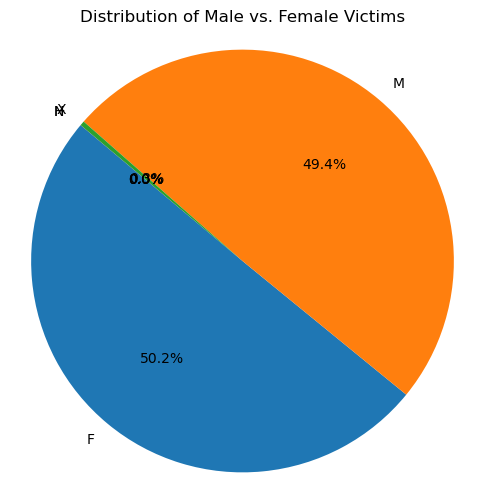

In [75]:
# Generate a pie plot showing the distribution of female versus male victims using Pandas
gender_counts = Data_complete['Victim Gender'].value_counts()
grouped_crimes = {}

# Create a pie plot
plt.figure(figsize=(6, 6))
plt.pie(gender_counts, labels=gender_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Male vs. Female Victims')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle

# Display the plot
plt.show()

#NEED VICTIM GENDER CLEANED

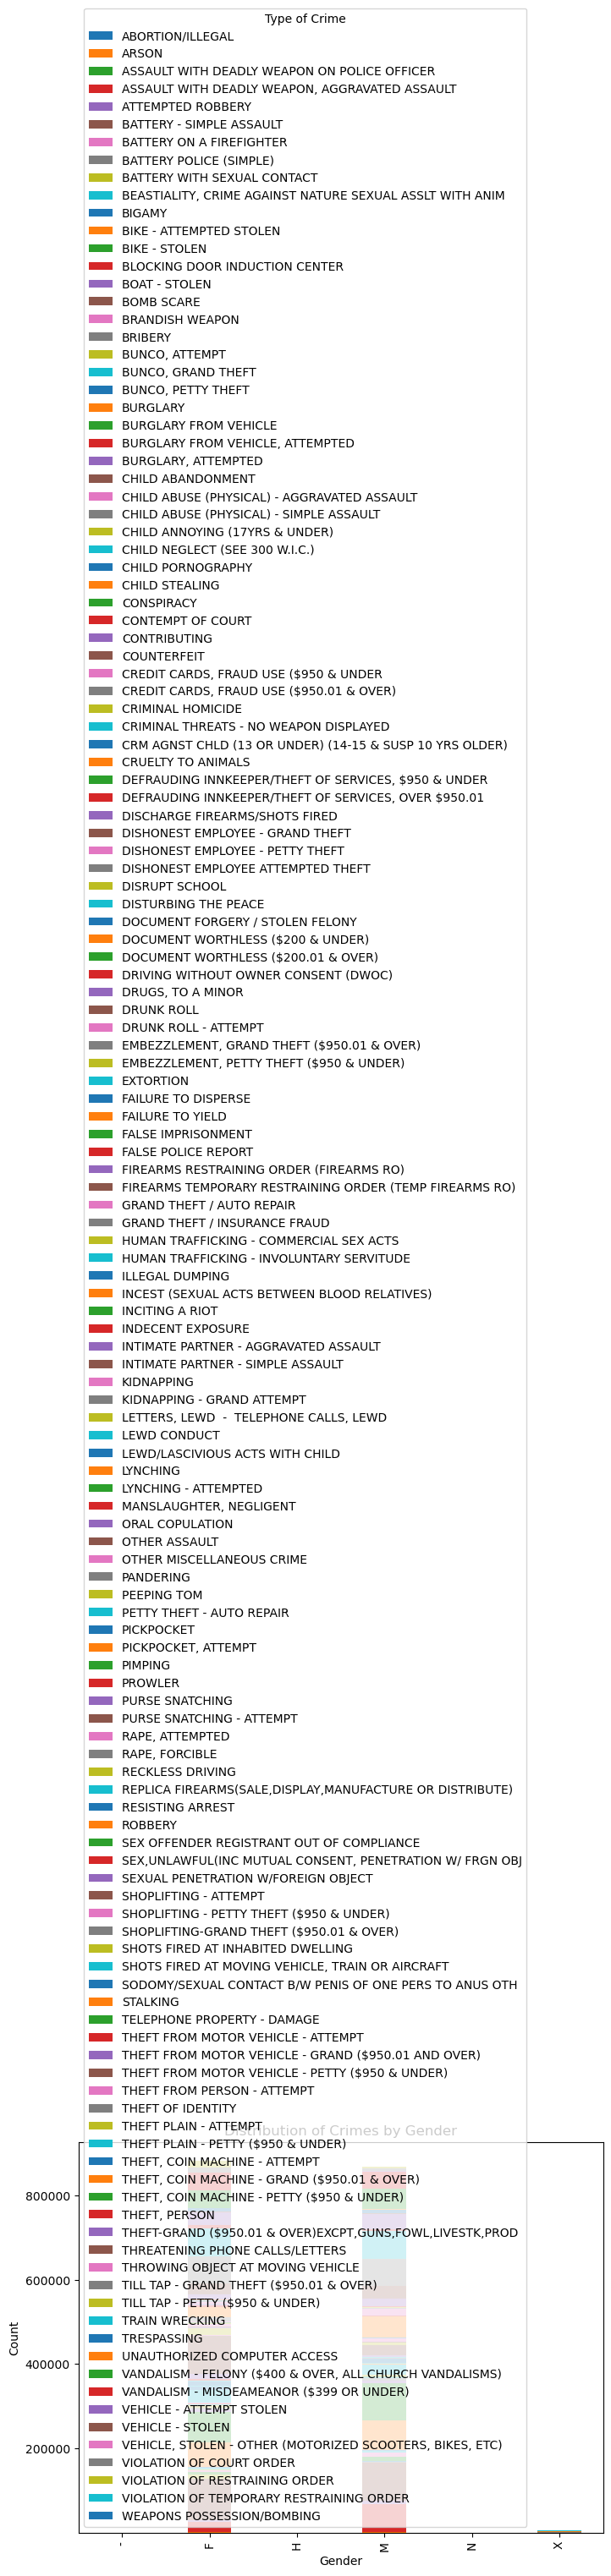

In [76]:
pivot_table = pd.crosstab(Data_complete['Victim Gender'], Data_complete['Type of Crime'])

# Create a stacked bar chart
pivot_table.plot(kind='bar', stacked=True, figsize=(8, 6))

# Customize the chart with labels and titles
plt.title('Distribution of Crimes by Gender')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.legend(title='Type of Crime')

# Display the plot
plt.show()

### Victim Race 

# Child Abuse compare over the years

## Change in crime spot

In [ ]:
#Splitting race by groups: Black, White, Hispanics, Asians

In [ ]:
#Splitting premise into 4 categories: Commercial, residential, industrial and outdoors
# using Bins

In [ ]:
#Percentage of increase and decrease in crimes over the years
Total_crime_count groupbyyear (count)

In [ ]:
 #How has crime changed over the years?
 
 Line graphs 